# BatchNormalization

## Resources
[Great Explanation](https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/)

[ML Explained](http://mlexplained.com/2018/01/10/an-intuitive-explanation-of-why-batch-normalization-really-works-normalization-in-deep-learning-part-1/)

[PaperSpace Blog](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/)

## Explanation
The objective of batch norm layer is to make input to the activation layer, unit Gaussian, so that neuron does not get saturate in case of `sigmoid` and `tanh`.
![batchnorm](https://imgur.com/RyBBETc.png)

### Covariate Shift
Covariate shift refers to the change in the distribution of the input values to a learning algorithm. A neural network changes the weights of each layer over the course of training. This means that the activations of each layer change as well. Since the activations of a previous layer are the inputs of the next layer, each layer in the neural network is faced with a situation where the input distribution changes with each step. This is problematic because it forces each intermediate layer to continuously adapt to its changing inputs.

The basic idea behind batch normalization is to limit covariate shift by normalizing the activations of each layer (transforming the inputs to be mean 0 and unit variance).

In practice, restricting the activations of each layer to be strictly 0 mean and unit variance can limit the expressive power of the network. Therefore, in practice, batch normalization allows the network to learn parameters $\gamma$  and $\beta$  that can convert the mean and variance to any value that the network desires.

### Issues
1. Even if the mean and variance are constant, the distribution of activations can still change. Why are the mean and variance so important?
2. If we introduce $\gamma$  and $\beta$ , the mean and variance will deviate from 0 and 1 anyway. What then, is the point of batch normalization?

## How to apply?
### Training
* Calculate mean and variance for each mini-batch. Normalize, the input activations by using these statistics.
* Parallely, we also update population statistics, by calculating the moving average of mini-batch mean and variance.

### Inference
Using batch normalization during inference can be a bit tricky. This is because we might not always have a batch during inference time. This is crucial since we need to compute the mean $(μ)$ and variance $(σ^2)$ of a batch to produce the output of the batch norm layer. 

In that case, we keep a **moving average of the mean and variance during training**, and then plug these values for the mean and the variance during inference. 

The **mean and variance of a mini-batch is a very noisy estimate of the true mean and the variance**. While the batch estimates are called the batch statistics, the true (unknown to us) values of mean and variance are called the **population statistics**. The law of large number states, that **for a large number of samples, the batch statistics will tend to converge to population statistics and that is why we use a moving average during training**. It also helps us even out the noise in the estimates produced owing to the mini batch nature of our optimization algorithm.

So, instead of batch mean$(μ)$ and variance$(σ2)$ we use population mean$(E[x])$ and variance$(Var[x])$ for normalization

## Position

While the original paper talks about applying batch norm just before the activation function, it has been found in practice that applying batch norm after the activation yields better results. This seems to make sense, as if we were to put a activation after batch norm, then the batch norm layer cannot fully control the statistics of the input going into the next layer since the output of the batch norm layer has to go through an activation. This is not the case with scenario where batch norm is applied after an activation.

## Advantages
* Batch normalization reduces the amount by what the hidden unit values shift around (covariance shift). 

>BatchNorm allows hidden layers to learn much more independently of the other layers.

* BatchNorm allows using high learning rates
* It has slight regularisation effect & hence prevents overfitting
* Some activation functions that might not have worked well previously in deep networks become viable again
* Allows you to be care free about weight initialization

Here, we see the effect of batchnormalization on 
* Training Time
* Learning Rate
* Model Performance
* Activation Function

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(X_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [4]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [5]:
print(X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


### Training Time

In [27]:
normal_model = Sequential()
normal_model.add(Input(shape=(28, 28, 1)))
normal_model.add(Convolution2D(32, (3,3), activation='relu'))
normal_model.add(MaxPooling2D(2,2))
normal_model.add(Convolution2D(64, (3,3), activation='relu'))
normal_model.add(MaxPooling2D(2,2))
normal_model.add(Convolution2D(64, (3,3), activation='relu'))
normal_model.add(Flatten())
normal_model.add(Dense(64, activation='relu'))
normal_model.add(Dense(10, activation='softmax'))

In [7]:
normal_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = normal_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 56s 933us/sample - loss: 0.2348 - accuracy: 0.9441 - val_loss: 0.0566 - val_accuracy: 0.9835
Epoch 2/5
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.0634 - accuracy: 0.9804 - val_loss: 0.0480 - val_accuracy: 0.9828
Epoch 3/5
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.0481 - accuracy: 0.9848 - val_loss: 0.0566 - val_accuracy: 0.9831
Epoch 4/5
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.0437 - accuracy: 0.9869 - val_loss: 0.0414 - val_accuracy: 0.9863
Epoch 5/5
60000/60000 [==============================] - 58s 969us/sample - loss: 0.0344 - accuracy: 0.9895 - val_loss: 0.0439 - val_accuracy: 0.9882


Each epoch took approximately *60-65* seconds.

In [28]:
batchnorm_model = Sequential()
batchnorm_model.add(Input(shape=(28, 28, 1)))
batchnorm_model.add(Convolution2D(32, (3,3), use_bias=False))
batchnorm_model.add(BatchNormalization())
batchnorm_model.add(Activation('relu'))
batchnorm_model.add(MaxPooling2D(2,2))
batchnorm_model.add(Convolution2D(64, (3,3), use_bias=False))
batchnorm_model.add(BatchNormalization())
batchnorm_model.add(Activation('relu'))
batchnorm_model.add(MaxPooling2D(2,2))
batchnorm_model.add(Convolution2D(64, (3,3), use_bias=False))
batchnorm_model.add(BatchNormalization())
batchnorm_model.add(Activation('relu'))
batchnorm_model.add(Flatten())
batchnorm_model.add(Dense(64, use_bias=False))
batchnorm_model.add(BatchNormalization())
batchnorm_model.add(Activation('relu'))
batchnorm_model.add(Dense(10, activation='softmax'))

In [10]:
batchnorm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
history_v2 = batchnorm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 77s 1ms/sample - loss: 0.1111 - accuracy: 0.9695 - val_loss: 0.0450 - val_accuracy: 0.9860
Epoch 2/5
60000/60000 [==============================] - 81s 1ms/sample - loss: 0.0416 - accuracy: 0.9880 - val_loss: 0.0342 - val_accuracy: 0.9893
Epoch 3/5
60000/60000 [==============================] - 88s 1ms/sample - loss: 0.0309 - accuracy: 0.9904 - val_loss: 0.0325 - val_accuracy: 0.9903
Epoch 4/5
60000/60000 [==============================] - 90s 1ms/sample - loss: 0.0247 - accuracy: 0.9923 - val_loss: 0.0271 - val_accuracy: 0.9919
Epoch 5/5
60000/60000 [==============================] - 90s 1ms/sample - loss: 0.0215 - accuracy: 0.9928 - val_loss: 0.0258 - val_accuracy: 0.9928


Each epoch took approximately *85-88* seconds.

**Accuracy of batchnorm model on both training and validation data compared to the normal model**

### Learning Rate

The default learning rate is *0.001* for Adam optimizer. Here, I increase it 10x to *0.01* & see if the model converges

Just recompiling & re-training the model should do the trick

In [29]:
normal_model.compile(optimizer=Adam(lr=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
history = normal_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 47s 782us/sample - loss: 0.5399 - accuracy: 0.9032 - val_loss: 0.2212 - val_accuracy: 0.9410
Epoch 2/5
60000/60000 [==============================] - 55s 924us/sample - loss: 0.2577 - accuracy: 0.9342 - val_loss: 0.2315 - val_accuracy: 0.9385
Epoch 3/5
60000/60000 [==============================] - 54s 908us/sample - loss: 0.2685 - accuracy: 0.9342 - val_loss: 0.2638 - val_accuracy: 0.9320
Epoch 4/5
60000/60000 [==============================] - 59s 981us/sample - loss: 0.2240 - accuracy: 0.9426 - val_loss: 0.1903 - val_accuracy: 0.9526
Epoch 5/5
60000/60000 [==============================] - 55s 922us/sample - loss: 0.2001 - accuracy: 0.9477 - val_loss: 0.1656 - val_accuracy: 0.9563


In [31]:
batchnorm_model.compile(optimizer=Adam(lr=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
history_v2 = batchnorm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.1118 - accuracy: 0.9701 - val_loss: 0.0682 - val_accuracy: 0.9778
Epoch 2/5
60000/60000 [==============================] - 81s 1ms/sample - loss: 0.0416 - accuracy: 0.9874 - val_loss: 0.0319 - val_accuracy: 0.9894
Epoch 3/5
60000/60000 [==============================] - 79s 1ms/sample - loss: 0.0305 - accuracy: 0.9905 - val_loss: 0.0332 - val_accuracy: 0.9891
Epoch 4/5
60000/60000 [==============================] - 82s 1ms/sample - loss: 0.0261 - accuracy: 0.9915 - val_loss: 0.0247 - val_accuracy: 0.9929
Epoch 5/5
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.0202 - accuracy: 0.9937 - val_loss: 0.0237 - val_accuracy: 0.9925


In [42]:
plt.rcParams["figure.figsize"] = (9, 6)

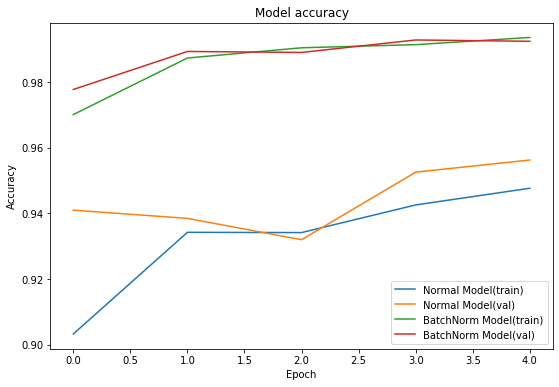

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_v2.history['accuracy'])
plt.plot(history_v2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Normal Model(train)', 'Normal Model(val)', 'BatchNorm Model(train)', 'BatchNorm Model(val)'], loc='best')
plt.show()

### Activation Function 

Looks like use of different activation function has not much effect when using BatchNorm. But when we use `sigmoid`, the gradients saturate & do not learn much

Notice, that here I'm replacing `relu` activation with `sigmoid` for hidden units and increased the learning rate from *0.001* by 10x to *0.01*

In [47]:
normal_model = Sequential()
normal_model.add(Input(shape=(28, 28, 1)))
normal_model.add(Convolution2D(32, (3,3), activation='sigmoid'))
normal_model.add(MaxPooling2D(2,2))
normal_model.add(Convolution2D(64, (3,3), activation='sigmoid'))
normal_model.add(MaxPooling2D(2,2))
normal_model.add(Convolution2D(64, (3,3), activation='sigmoid'))
normal_model.add(Flatten())
normal_model.add(Dense(64, activation='sigmoid'))
normal_model.add(Dense(10, activation='softmax'))

In [48]:
normal_model.compile(optimizer=Adam(lr=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [49]:
history = normal_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 128s 2ms/sample - loss: 2.3321 - accuracy: 0.1028 - val_loss: 2.3456 - val_accuracy: 0.1028
Epoch 2/5
60000/60000 [==============================] - 118s 2ms/sample - loss: 2.3298 - accuracy: 0.1019 - val_loss: 2.3198 - val_accuracy: 0.1032
Epoch 3/5
60000/60000 [==============================] - 119s 2ms/sample - loss: 2.3307 - accuracy: 0.1033 - val_loss: 2.3290 - val_accuracy: 0.1010
Epoch 4/5
60000/60000 [==============================] - 101s 2ms/sample - loss: 2.3312 - accuracy: 0.0999 - val_loss: 2.3218 - val_accuracy: 0.1135
Epoch 5/5
60000/60000 [==============================] - 77s 1ms/sample - loss: 2.3278 - accuracy: 0.1026 - val_loss: 2.3369 - val_accuracy: 0.1009


In [50]:
batchnorm_model = Sequential()
batchnorm_model.add(Input(shape=(28, 28, 1)))
batchnorm_model.add(Convolution2D(32, (3,3), use_bias=False))
batchnorm_model.add(BatchNormalization())
batchnorm_model.add(Activation('sigmoid'))
batchnorm_model.add(MaxPooling2D(2,2))
batchnorm_model.add(Convolution2D(64, (3,3), use_bias=False))
batchnorm_model.add(BatchNormalization())
batchnorm_model.add(Activation('sigmoid'))
batchnorm_model.add(MaxPooling2D(2,2))
batchnorm_model.add(Convolution2D(64, (3,3), use_bias=False))
batchnorm_model.add(BatchNormalization())
batchnorm_model.add(Activation('sigmoid'))
batchnorm_model.add(Flatten())
batchnorm_model.add(Dense(64, use_bias=False))
batchnorm_model.add(BatchNormalization())
batchnorm_model.add(Activation('sigmoid'))
batchnorm_model.add(Dense(10, activation='softmax'))

In [51]:
Looksbatchnorm_model.compile(optimizer=Adam(lr=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [52]:
history_v2 = batchnorm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 160s 3ms/sample - loss: 0.1294 - accuracy: 0.9635 - val_loss: 0.1542 - val_accuracy: 0.9547
Epoch 2/5
60000/60000 [==============================] - 184s 3ms/sample - loss: 0.0591 - accuracy: 0.9822 - val_loss: 0.0495 - val_accuracy: 0.9834
Epoch 3/5
60000/60000 [==============================] - 193s 3ms/sample - loss: 0.0442 - accuracy: 0.9868 - val_loss: 0.1105 - val_accuracy: 0.9660
Epoch 4/5
60000/60000 [==============================] - 274s 5ms/sample - loss: 0.0348 - accuracy: 0.9890 - val_loss: 0.1020 - val_accuracy: 0.9684
Epoch 5/5
60000/60000 [==============================] - 110s 2ms/sample - loss: 0.0322 - accuracy: 0.9901 - val_loss: 0.0921 - val_accuracy: 0.9725


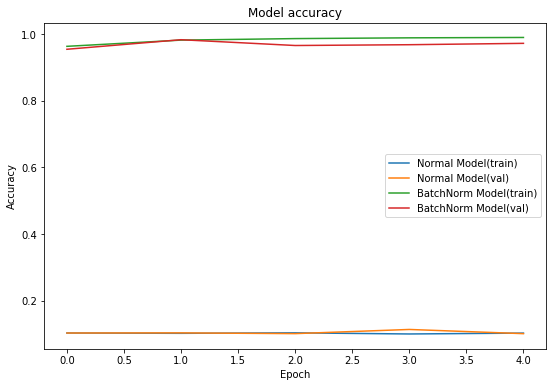

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_v2.history['accuracy'])
plt.plot(history_v2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Normal Model(train)', 'Normal Model(val)', 'BatchNorm Model(train)', 'BatchNorm Model(val)'], loc='best')
plt.show()

Definitely BatchNorm avoids neurons from getting saturated when using `sigmoid` or `tanh` activation function